
 ## DeePlexiCon
 ### Analyse and demultiplex Oxford Nanopore RNA barcoded with DNA Adaptors Directly from the Signal
 
 Supplement Jupyter Notebook for the paper "Barcoding and demultiplexing Oxford Nanopore direct RNA sequencing reads using deep learning"
 
Preparation:


In [1]:
# System support
from __future__ import print_function
import os
import platform
from copy import deepcopy
import re
import csv
import time
import configparser
# Math,Numpy and plot
import math
import numpy as np
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
#import PIL
#from PIL import Image
# Time series to 2D
import pyts
# Tensorflow - Keras
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
# Datasets, train test split
import pandas as pd
import sklearn
from sklearn import datasets, linear_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd

import seaborn as sn

Using TensorFlow backend.


In [2]:
def version_from_system(package):
    pkg_info=!pip show {package}
    return(pkg_info[1][9:])   

print("Python       version :",platform.python_version())
print("pip          version :",version_from_system('pip'))
print("Tensorflow   version :",tf.__version__)
print("Keras        version :",keras.__version__)
print("Numpy        version :",np.__version__)
print("Matplotlib   version :",matplotlib.__version__)
print("Pandas       version :",pd.__version__)
print("PyTs         version :",pyts.__version__)
print("Scikit-learn version :",sklearn.__version__)
#print("PIL          version :",PIL.__version__)
print("Seaborn      version :",sn.__version__)
print("PYCM         version :",version_from_system('pycm'))

Python       version : 3.7.3
pip          version : 19.1.1
Tensorflow   version : 1.13.1
Keras        version : 2.2.4
Numpy        version : 1.16.4
Matplotlib   version : 3.1.0
Pandas       version : 0.25.0
PyTs         version : 0.8.0
Scikit-learn version : 0.21.2
Seaborn      version : 0.9.0
PYCM         version : 2.4


In [58]:
# Parameters
run='rep1-on-rep2-4-test1'
gpus=1
epochs=40
input_cut=70000
input_data_paths=['/data/nanopore/James/Barcodes/final-07-19/tsv']
input_segment_paths=['/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split']#, '/data/nanopore/James/Barcodes/final-07-19/seg/rep2-split']
squiggle_max=199.0
squiggle_min=10
print_details_for=5
max_sample=64000
read_max=180000
smooth_by=1
num_classes=4
label_index=1
save_figures=True

In [4]:
!mkdir -p {run}

In [59]:
10# Python timeseries interface
from pyts.image import MarkovTransitionField, GramianAngularField, RecurrencePlot
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 6,
        }
# Python timeseries interface
def pyts_transform(name,transform,data,image_size,show=False,cmap='rainbow',img_index=0):
    try:
        X_transform = transform.fit_transform(data)
        if (show):
            tcn=transform.__class__.__name__
            if hasattr(transform, 'method'):
                tcn=tcn+'-'+transform.method
            plt.figure(figsize=(4, 4))
            plt.grid(b=None)
            plt.title(name,fontdict=font)
            plt.imshow(X_transform[0], cmap=cmap, origin='lower')
            if save_figures: plt.savefig(run+"/"+name+'-'+tcn+"_image_"+ str(img_index)+".svg", format="svg")
            plt.show()
        return(X_transform)
    except Exception as e:
        print('Error:', str(e))
        return([])
        
def mtf_transform(name,data,image_size = 500,show=False,img_index=0):
    transform = MarkovTransitionField(image_size)    
    return(name,pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))
    
def rp_transform(name,data,image_size = 500,show=False,img_index=0):
    # RP transformation
    transform = RecurrencePlot(dimension=1, 
                    threshold='percentage_points',
                    percentage=30)
    return(pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='binary',img_index=img_index))
    
def gasf_transform(name,data,image_size = 500,show=False,img_index=0):
    # GAF transformation
    transform = GramianAngularField(image_size, method='summation')
    return(pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))

def gadf_transform(name,data,image_size = 500,show=False,img_index=0):
    # GAF transformation
    transform = GramianAngularField(image_size, method='difference')
    return(name,pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))
     


In [10]:
def all_files_in_path(input_path,prefix, extension):
    return([f for f in os.listdir(input_path) if f.startswith(prefix) & f.endswith(extension)])

def full_paths_for_files_in_path(input_path,prefix, extension):
    return([input_path+'/'+f for f in os.listdir(input_path) if f.startswith(prefix) & f.endswith(extension)])

def labels_for(file_name):
    segments=re.split(r'[_\-\.]+', file_name)
    return(segments)

def label_for(file_name):
    return('BC'+labels_for(file_name)[label_index][-1])

def max_in_sequence(sequence):   
    return(max(np.amax([list(d.values()) for d in sequence]),0.01))

In [11]:
for file_name in all_files_in_path(input_segment_paths[0],'', '.tsv'):
    print(file_name,label_for(file_name))

rep1-SH4_segments.tsv BC4
rep1-SH3_segments.tsv BC3
rep1-SH2_segments.tsv BC2
rep1-SH1_segments.tsv BC1


In [63]:
def read_segment_files(paths,postfix,usecols=[0,1,2,3],index_column=1, names=['source','read_id', 'segment_start','segment_end']):
    all_segment_files=[]
    for path in paths:
        all_segment_files=all_segment_files+full_paths_for_files_in_path(path,'',postfix)
    print("Reading segment files:", all_segment_files)
    segments=[]
    for f in all_segment_files:
        segment_label=label_for(os.path.basename(f)) # Assuming Linux, may fail with Windows
        segment=pd.read_table(f, usecols=usecols, names=names, index_col=index_column, header=None, sep=' ')
        segment['label']=segment_label
        segments.append(segment)
    segments=pd.concat(segments)
    print(len(segments))
    segments = segments[~segments.index.duplicated(keep='first')]
    print(len(segments))
    return(segments)

In [64]:
print(full_paths_for_files_in_path(input_segment_paths[0],'', '.tsv'))

['/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split/rep1-SH4_segments.tsv', '/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split/rep1-SH3_segments.tsv', '/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split/rep1-SH2_segments.tsv', '/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split/rep1-SH1_segments.tsv']


In [65]:
segments=read_segment_files(input_segment_paths, '.tsv')
segments

Reading segment files: ['/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split/rep1-SH4_segments.tsv', '/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split/rep1-SH3_segments.tsv', '/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split/rep1-SH2_segments.tsv', '/data/nanopore/James/Barcodes/final-07-19/seg/rep1-split/rep1-SH1_segments.tsv']
32955
32955


,source,segment_start,segment_end,label
read_id,,,,
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_6786_ch_180_strand.fast5,0003f155-77f8-4a2e-8331-ebcaf3bc94f5,5047,11068,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_6570_ch_417_strand.fast5,0007d4a0-86f1-41d5-ba80-07695c4e81e9,4147,9538,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_14002_ch_72_strand.fast5,000a8689-5b00-4689-8129-6f4392907945,3900,8403,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_20590_ch_388_strand.fast5,000c1e97-3927-4a6d-ac3c-cbb651f66380,5416,9917,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_28283_ch_410_strand.fast5,000d8999-23e5-4e04-9415-0034f97aaccc,5667,14121,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_7697_ch_499_strand.fast5,001a0440-2ccb-42f9-bac0-0c5edfba74a6,2795,5807,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_3781_ch_455_strand.fast5,001c74e4-27fe-4abf-a6a9-b0b7c1b63465,3081,9825,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_9296_ch_175_strand.fast5,001d7b98-ecba-417b-a23e-0bd86bc9bc32,3486,9225,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_6454_ch_383_strand.fast5,001e69f2-7f0e-4f81-a90a-46fef2d9f9ab,7619,16654,BC4


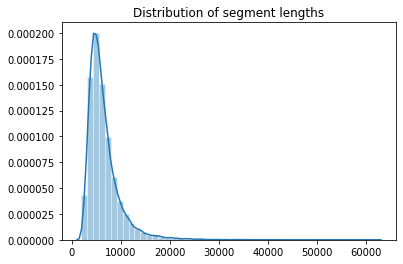

In [15]:
from matplotlib.ticker import FuncFormatter

seg_lengths=segments['segment_end']-segments['segment_start']+1
#seg_lengths=seg_lengths[seg_lengths<20000]
#print(seg_lengths[0:20])

plt.figure("Distribution of segment lengths")
plt.title("Distribution of segment lengths")
sn.set(rc={'figure.figsize':(18.7,10.27)})
sn.set_style("whitegrid")
sn.distplot(seg_lengths)#, bins=100, kde=False, color="blue", label="S1")
#plt.legend()
if save_figures: plt.savefig(run+"/seglengthdist1.svg", format="svg")
plt.show()
seg_lengths=None


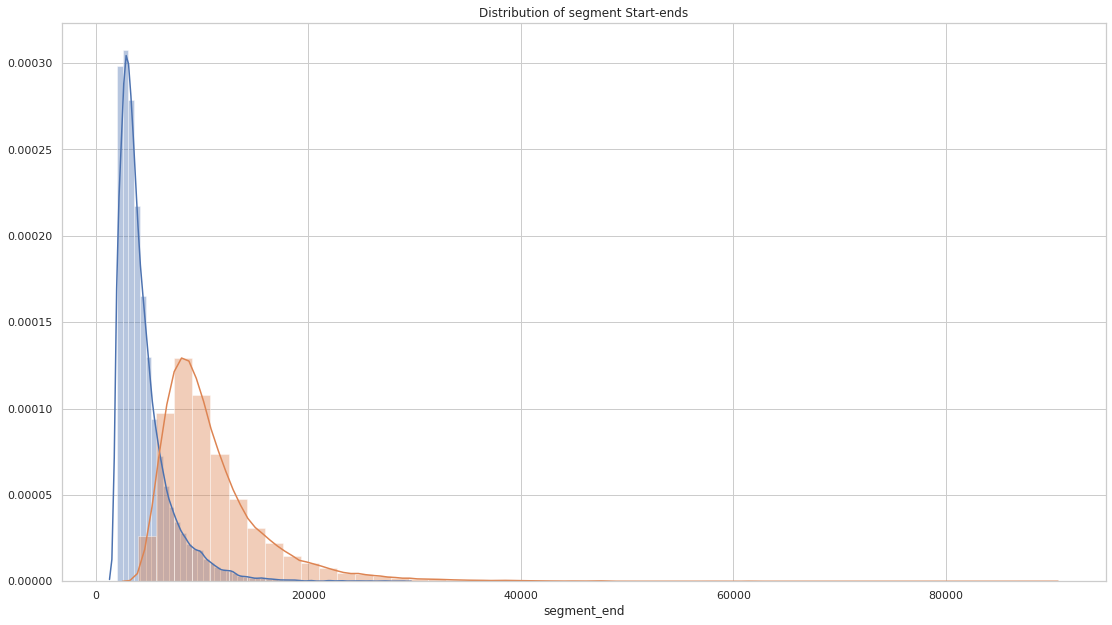

In [16]:

plt.figure("Distribution of segment Start-ends")
plt.title("Distribution of segment Start-ends")
sn.set(rc={'figure.figsize':(18.7,10.27)})
sn.set_style("whitegrid")
sn.distplot(segments['segment_start'][segments['segment_start']<30000])#, bins=100, kde=False, color="blue", label="S1")
sn.distplot(segments['segment_end'])#, bins=100, kde=False, color="blue", label="S1")
#plt.legend()
if save_figures: plt.savefig(run+"/segst-end-dist1.svg", format="svg")
plt.show()



In [ ]:
segments.loc['03f3bb7f-7d34-4b17-b045-cdac3aab6a81']

In [62]:
segments.describe()

NameError: name 'segments' is not defined

In [19]:
far_ends= segments[segments['segment_end']>30000]

In [20]:
long_segments= segments[(segments['segment_end']-segments['segment_start'])>30000]

In [21]:
far_ends

,source,segment_start,segment_end,label
read_id,,,,
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_61995_ch_24_strand.fast5,00898253-ff64-494c-bd61-ea37bfcb0ac9,22662,31324,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_46268_ch_329_strand.fast5,01026a03-b0c2-4f8f-b3bf-258c068554e0,18634,30315,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_26314_ch_217_strand.fast5,01292a0d-811e-43da-b784-c98b09ff4647,37966,44859,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_6170_ch_504_strand.fast5,0160dfc1-72e3-40ac-a675-e47ea46f5b2d,12051,32806,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_7735_ch_179_strand.fast5,023b06ea-a450-4deb-8283-1e6e59c10aa2,8829,32269,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_13072_ch_499_strand.fast5,02b12220-7d32-4af8-abf1-c6fb2a8c2094,3653,38304,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_40411_ch_85_strand.fast5,03dd490a-cba7-4564-b299-d25e4ab5f422,26096,38985,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_3642_ch_409_strand.fast5,04b7088e-582c-422c-9b1a-56119d4cf0d5,7496,30817,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_44090_ch_119_strand.fast5,05cbda84-a9c9-4bfd-9bd5-cd42da864ef3,9059,32528,BC4


In [22]:
long_segments

,source,segment_start,segment_end,label
read_id,,,,
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_13072_ch_499_strand.fast5,02b12220-7d32-4af8-abf1-c6fb2a8c2094,3653,38304,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_53672_ch_476_strand.fast5,0c12a9d0-f1f7-4e5a-92f8-10e58a6170ac,19253,72979,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_59189_ch_73_strand.fast5,2671688b-80e8-40b9-b177-db89a6c8ddf7,23636,64488,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_8222_ch_110_strand.fast5,28c65d59-9607-4cb2-9e78-27e3bb944522,9417,58203,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_27865_ch_157_strand.fast5,31d990b6-6ad7-4bf6-9bf3-9305cb7bd948,12734,46592,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_11212_ch_448_strand.fast5,3a232e6d-6285-4cf3-8db6-0fdef9fce85a,10536,41162,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_13216_ch_502_strand.fast5,53744f19-6f0f-4487-8eb6-5d544db90c3d,24396,75017,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_258423_ch_15_strand.fast5,565317be-cccd-4031-9d5d-2662a4481246,10625,42105,BC4
gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_18437_ch_290_strand.fast5,58af0e76-39b9-42bb-82b6-a18f0ec7025c,7443,38676,BC4


In [23]:
fe_csv = far_ends.to_csv (run+'/far_ends.csv',  header=True)
ls_csv = long_segments.to_csv (run+'/long_segments.csv',  header=True)

In [32]:
offset=-1000
buffer=0
def segment_by_read_name(read_name):
    try:
        seg=segments.loc[read_name]
        return(seg['segment_start']+offset-buffer,seg['segment_end']+offset+buffer,seg['label'])
    except:
        return(None,None, None)

In [25]:
segment_by_read_name('57eeb899-e5f7-4e18-bd02-e7618849e05b')

(None, None, None)

In [27]:
files_to_process=[]
for path in input_data_paths:
    files_to_process=files_to_process+all_files_in_path(path,'','.tsv')

print (len(files_to_process))
for f in files_to_process:
    print(labels_for(f))

1
['rep1', 'squiggle', 'tsv']


In [66]:
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
image_size=224
samples={'BC1':0,'BC2':0,'BC3':0,'BC4':0}
def compress_squiggle(squiggle,compress_factor):
    squiggle_len=len(squiggle)
    rem=squiggle_len%compress_factor
    if rem>0:
        return(np.mean(squiggle[0:squiggle_len-rem].reshape(-1,compress_factor), axis=1))
    return(squiggle)
    
def show_graph(squiggle_label,squiggle, trimmed_squiggle,segments=[], img_index=0):
    squiggle_for_plot=pd.DataFrame(np.trim_zeros(squiggle))
    plt.figure(figsize=(15,2))
    plt.grid(True)
    for seg in segments:
        plt.axvline(x=seg[0]/smooth_by, color=seg[2])
        plt.axvline(x=seg[1]/smooth_by, color=seg[2])
    plt.plot(squiggle_for_plot, linewidth=0.1, color='black')
    plt.title(squiggle_label)
    if save_figures: plt.savefig(run+"/"+squiggle_label+"-squiggle"+ str(img_index)+".svg", format="svg")
    plt.show()
    plt.figure(figsize=(15,2))
    plt.plot(trimmed_squiggle, linewidth=0.2, color='black')
    plt.title(squiggle_label)
    plt.grid(True)
    if save_figures: plt.savefig(run+"/"+squiggle_label+"-seg-squiggle-"+str(img_index)+".svg", format="svg")
    plt.show()
    
def process_file(data_path,file_to_process,  pos_from, pos_to):
    print('Processing file:', file_to_process)
    squiggles=[]
    squiggle_labels=[]
    start_from=5
    start=time.time()
    printed_details=0
    image_index=0
    labels=[]
    result=[]
    lines_read=0
    with open(data_path+'/'+file_to_process) as tsv:
        for line in csv.reader(tsv, dialect="excel-tab"):
#            try:
                squiggle_label=line[0]
                segment_start,segment_end, label=segment_by_read_name(squiggle_label)
                segments=[[segment_start, segment_end, 'r']]
                if segment_start is not None:
                    squiggle=np.array(line[start_from:], dtype=np.float32)
                    if len(squiggle)>=image_size:
                        lines_read=lines_read+1
                        #take average of every n points to compress by n
                        if (smooth_by > 1) and (len(squiggle)> smooth_by * image_size):
                            squiggle=compress_squiggle(squiggle,smooth_by) 
                            segment_start=int(segment_start/smooth_by)
                            segment_end=int(segment_end/smooth_by)
                        trimmed_squiggle=squiggle[segment_start:segment_end+1]
                        squiggle=squiggle[squiggle <= squiggle_max]
                        squiggle=squiggle[squiggle > squiggle_min]
                        trimmed_squiggle=trimmed_squiggle[trimmed_squiggle <= squiggle_max]
                        trimmed_squiggle=trimmed_squiggle[trimmed_squiggle > squiggle_min]
                        trimmed_squiggle=np.trim_zeros(trimmed_squiggle)
                        display_graph=printed_details<print_details_for
                        name=label+'-'+squiggle_label
                        if (display_graph):
                            print("Reading:", squiggle_label)
                            show_graph(name,squiggle,trimmed_squiggle,segments=segments,img_index=image_index)
                            image_index=image_index+1
                            printed_details=printed_details+1
#                        transformed_squiggle=mtf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
#                        transformed_squiggle=rp_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
#                        transformed_squiggle=gadf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
                        transformed_squiggle=gasf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
                        if (display_graph):
                            image_index=image_index+1
                        if len(transformed_squiggle)>0:
                            if samples[label]<max_sample:
                                transformed_squiggle=transformed_squiggle[None,...]
                                result.append([label,squiggle_label, transformed_squiggle])
                                samples[label]=samples[label]+1
                        else:
                            print("Transformation fails:", squiggle_label,len(transformed_squiggle))
                    else:
                        print("Short:", squiggle_label,len(squiggle))
                else:
                    print("No segment info for:", squiggle_label)
                if (lines_read>=read_max) or (min(samples.values())>=max_sample):
                    break
#            except Exception as e:
#               print('Error:', str(e),segment_start)
    print( "Number of Squiggles=", len(result))
    print(time.time()-start, ' seconds') 
    return(result)#[labels, squiggle_labels,squiggles])


/data/nanopore/James/Barcodes/final-07-19/tsv
File name= /data/nanopore/James/Barcodes/final-07-19/tsv/rep1-squiggle.tsv
Processing file: rep1-squiggle.tsv
Reading: gru_20171207_FAH30963_MN20855_mux_scan_RNA_Unlabeled_Barcoded_49637_read_105_ch_509_strand.fast5


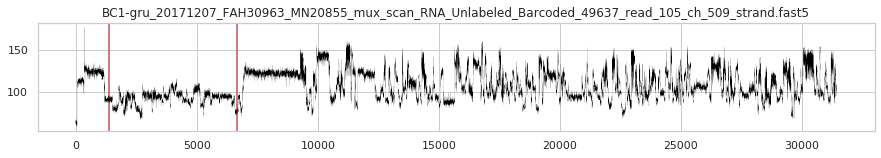

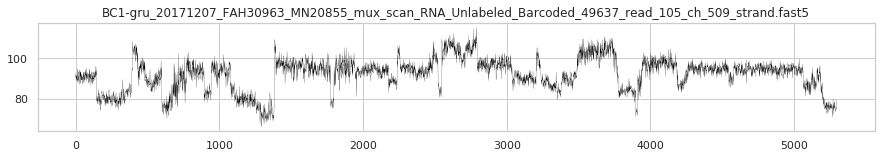

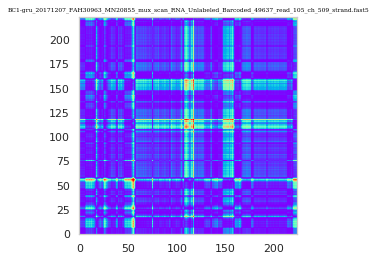

Reading: gru_20171207_FAH30963_MN20855_mux_scan_RNA_Unlabeled_Barcoded_49637_read_113_ch_290_strand.fast5


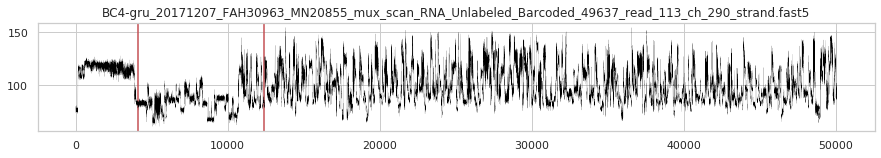

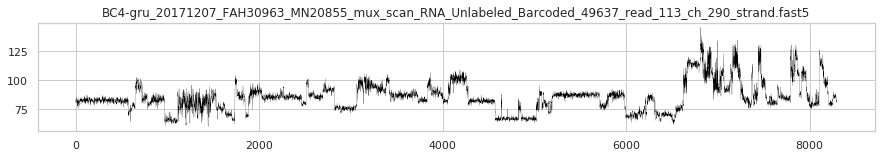

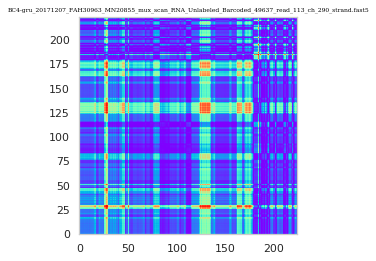

Reading: gru_20171207_FAH30963_MN20855_mux_scan_RNA_Unlabeled_Barcoded_49637_read_114_ch_5_strand.fast5


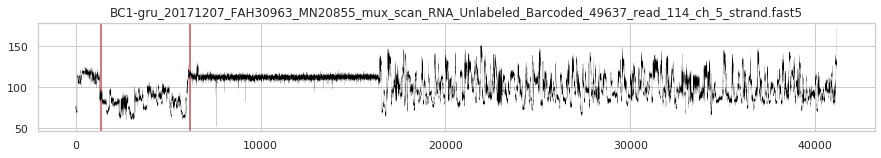

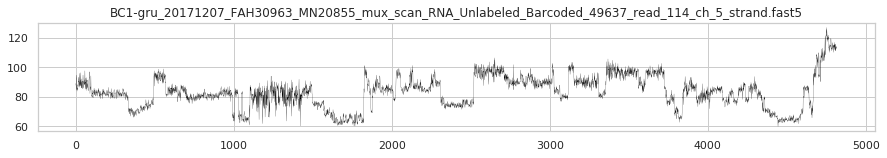

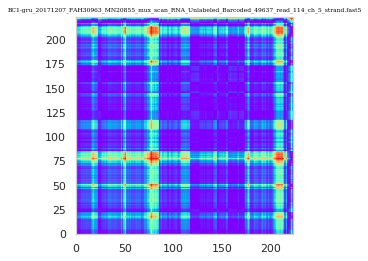

Reading: gru_20171207_FAH30963_MN20855_mux_scan_RNA_Unlabeled_Barcoded_49637_read_1157_ch_288_strand.fast5


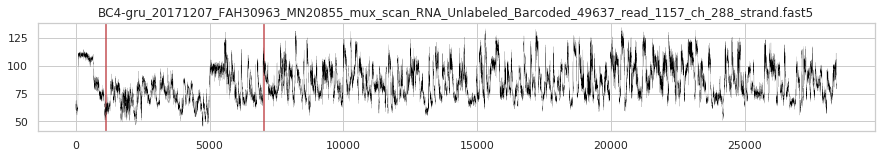

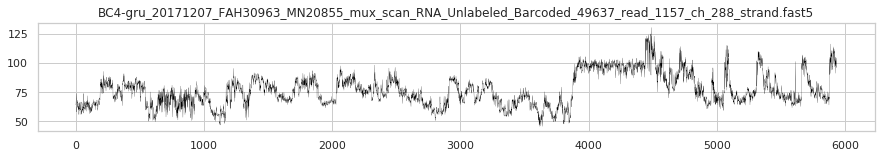

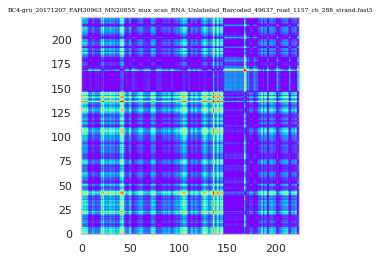

Reading: gru_20171207_FAH30963_MN20855_mux_scan_RNA_Unlabeled_Barcoded_49637_read_117_ch_306_strand.fast5


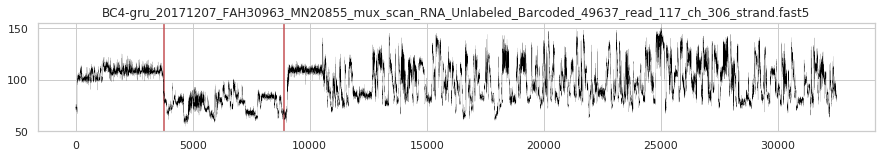

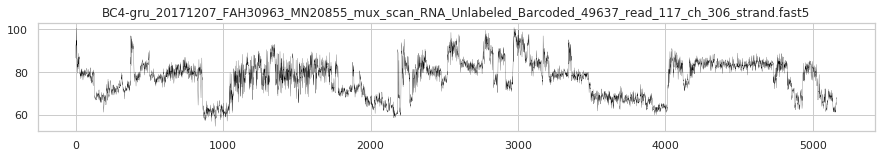

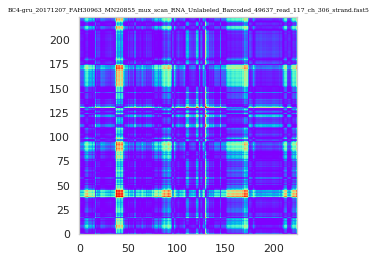

No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_2697_ch_30_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_13483_ch_14_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_13629_ch_467_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_26553_ch_439_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_41402_ch_219_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_32328_ch_189_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_43271_ch_470_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_6707_ch_19_strand.fas

No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_11108_ch_428_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_38808_ch_152_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_6219_ch_291_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_23477_ch_267_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_15884_ch_218_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_2319_ch_450_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_27276_ch_329_strand.fast5
No segment info for: gru_20171207_FAH30963_MN20855_sequencing_run_RNA_Unlabeled_Barcoded_80746_read_21401_ch_52_strand.f

In [67]:
%%time

result={}
for data_path in input_data_paths:
    print(data_path)
    for fn in all_files_in_path(data_path,'','squiggle.tsv'):
        file_name=data_path+'/'+fn
        print('File name=',file_name)
        summary=process_file(data_path,fn, 5, 10)
        for label, squiggle_label, img in summary:
            if label not in result:
                result[label]=[]
            result[label].append([squiggle_label,img])
        for key,value in result.items():
            print(key, '=',len(value), 'samples now')
del segments #No need after conversion

In [35]:
print(samples)

{'BC1': 11395, 'BC2': 3272, 'BC3': 688, 'BC4': 17600}


In [ ]:
for i,v in times.items():
    print(i, sum(v), len(v),sum(v)/len(v))

In [45]:
#%%time
#import pickle
#with open('images.px', 'wb') as fp:
#    pickle.dump(result, fp, protocol=4) 

4.248104572296143  seconds


In [48]:
#%%time
#with open ('images.px', 'rb') as fp:
#    result = pickle.load(fp, encoding="bytes") 

0.46711015701293945  seconds


In [28]:
print([len(val) for val in result.values()])

[]


In [36]:
for key,value in result.items():
    print(key,len(value))
    
#SH1= 75685  SH2= 82725  SH3= 60041  SH4= 80367 Previous runs
#BC1 45000 BC2 16494 BC3 35197 BC4 22313 Previous runs

BC1 11395
BC4 17600
BC2 3272
BC3 688


In [37]:
np.mean([np.mean(elm[1]) for elm in result['BC4']])

-0.7079861834611448

In [35]:
64000+16494+35197+22313

138004

In [38]:
from sklearn.utils import shuffle

train_size=0
test_size=140000
test_val_split=0.99999
def prep_data(in_labels,raw_data,desired_size,y_value,shuffle_data=False,):
    data=deepcopy(raw_data)
    labels=deepcopy(in_labels)
    if shuffle_data:
        labels,data=shuffle(in_labels,data)
    data=data[0:desired_size]
    labels=labels[0:desired_size]
    results = np.empty((len(data),num_classes))
    results[0:len(data)]=y_value
    return(labels,data,results)
    
sh1=np.array(result['BC1'])
sh2=np.array(result['BC2'])
sh3=np.array(result['BC3'])
sh4=np.array(result['BC4'])
sh1d=np.vstack(sh1[:,1])
sh2d=np.vstack(sh2[:,1])
sh3d=np.vstack(sh3[:,1])
sh4d=np.vstack(sh4[:,1])
#result=None
labels,data,exp_values=prep_data(sh1[:,0],sh1d,train_size,[1,0,0,0],shuffle_data=True)
LX=labels
X=np.array(data)
y=exp_values
labels,data,exp_values=prep_data(sh1[:,0][train_size:],sh1d[train_size:],test_size,[1,0,0,0],shuffle_data=False)
LX_test=labels
X_test=np.array(data)
Y_test=exp_values
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', LX.shape, X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh2[:,0],sh2d,train_size,[0,1,0,0],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh2[:,0][train_size:],sh2d[train_size:],test_size,[0,1,0,0],shuffle_data=False)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test = np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh3[:,0],sh3d,train_size,[0,0,1,0],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh3[:,0][train_size:],sh3d[train_size:],test_size,[0,0,1,0],shuffle_data=False)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test =np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh4[:,0],sh4d,train_size,[0,0,0,1],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh4[:,0][train_size:],sh4d[train_size:],test_size,[0,0,0,1],shuffle_data=True)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test = np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

#del result,sh1,sh2,sh3,sh4,sh1d,sh2d,sh3d,sh4d
#X_test_labels, X_test, Y_test=
#X_validation_labels, X_validation, Y_validation =train_test_split(X_test, y_test, test_size=0.5, shuffle=True)
LX_test, X_test, Y_test=shuffle(LX_test, X_test, Y_test)
split_point=int(len(X_test)*test_val_split)
print("splitting at=",split_point)
LX_validation=LX_test[split_point:]
X_validation=X_test[split_point:]
Y_validation=Y_test[split_point:]
LX_test=LX_test[0:split_point]
X_test=X_test[0:split_point]
Y_test=Y_test[0:split_point]

print('Tst LX=', len(LX_test))
print('Tst X=', X_test.shape)
print('Tst y=',Y_test.shape)
print('Val LX=', len(LX_validation))
print('Val X=', X_validation.shape)
print('Val y=',Y_validation.shape)


lx,x,y,labels, lxt, x_test y_test shapes= (0,) (0, 1, 224, 224) (0, 4) 11395 11395 (11395, 1, 224, 224) (11395, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 3272 14667 (14667, 1, 224, 224) (14667, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 688 15355 (15355, 1, 224, 224) (15355, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 17600 32955 (32955, 1, 224, 224) (32955, 4)
splitting at= 32954
Tst LX= 32954
Tst X= (32954, 1, 224, 224)
Tst y= (32954, 4)
Val LX= 1
Val X= (1, 1, 224, 224)
Val y= (1, 4)


In [ ]:
X_test[0]

In [39]:
"""Defines a ResNet on the nanopore dataset.

ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf

ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""
#tensorboard = keras.callbacks.TensorBoard(log_dir="log-full/{}".format(time.time()), histogram_freq=20, write_graph=True)

# Training parameters
batch_size = 32*gpus  # multiply by number of GPUs 
data_augmentation = False

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
    
X_train=X
Y_train=y

In [ ]:
print(X_test)

In [40]:
# Devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

def _get_available_devices():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print (_get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']


In [41]:
# Model name, depth and version
model_type = 'UResNet%dv%d' % (depth, version)
print('model_type=',model_type)
# Input image dimensions.

input_shape = X_train.shape[1:]
print('input_shape=',input_shape)
# Normalize data.
"""
x_train = X_train #/ 255
x_test = X_test #/ 255
x_validation = X_validation #/ 255
"""
x_train = X_train +1
x_train /= 2
x_test = X_test+1
x_test /= 2 
x_validation = X_validation +1
x_validation /= 2

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    print (x_train_mean)
    x_train -= x_train_mean
    x_test -= x_train_mean
    x_validation -= x_train_mean
    

print('x_train shape:', x_train.shape)
print(x_test.shape[0], 'test samples')
print(x_validation.shape[0], 'validation samples')
print('y_train shape:', Y_train.shape)

# Convert class vectors to binary class matrices.
y_train = Y_train #keras.utils.to_categorical(Y_train, num_classes)
y_test = Y_test #keras.utils.to_categorical(Y_test, num_classes)
y_validation=Y_validation

model_type= UResNet20v2
input_shape= (1, 224, 224)
x_train shape: (0, 1, 224, 224)
32954 test samples
1 validation samples
y_train shape: (0, 4)


In [42]:
np.mean([np.mean(elm) for elm in x_test])

0.14777690740603033

In [43]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 10, 20, 30, 50 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 50:
        lr *= 0.5e-3
    elif epoch > 35:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [44]:
from keras.models import load_model
model = load_model('/data/nanopore/James/Barcodes/saved_models/pAmps-rep2-4-train1_newdata_nanopore_UResNet20v2_model.016.h5')
#model = load_model('saved_models/run03_nanopore_UResNet20v2_model.045.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [45]:
# Validate trained model.
scores = model.evaluate(x_validation, y_validation, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])
#print(scores) 0.950775

1/1 [==============================] - 6s 6s/step
Validation loss: 0.6716530323028564
Validation accuracy: 1.0


In [46]:
# Test trained model.
test_scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
#print(test_scores)
#Test loss: 0.6517597238560011
#Test accuracy: 0.839674963447996 then .8852


32954/32954 [==============================] - 89s 3ms/step
Test loss: 9.622174578210194
Test accuracy: 0.08478485161359792


In [47]:
y_predicted = model.predict(x_validation, verbose=1)


1/1 [==============================] - 1s 1s/step


In [38]:
y_val_pred=np.round(y_predicted,decimals=2)
y_val_act=np.round(y_validation,decimals=2)
print(y_val_pred[10:50])
print(y_val_act[10:50])
y_val_pred_act=np.concatenate((y_val_pred,y_val_act), axis = 1 )

[]
[]


In [48]:
def  spectifity(true_negatives,false_positives):
    return(true_negatives/(true_negatives+false_positives))

def sensitivity(true_positives,false_negatives):
    return(true_positives/(true_positives+false_negatives))

def confidence_margin(npa):
    sorted=np.sort(npa)[::-1]    #return sort in reverse, i.e. descending
    return(sorted[0])#-sorted[1])
print(confidence_margin([0.0, 0.0, 0.5, 0.0]))

def result_for(npa):
    half=len(npa)//2
    return(np.argmax(npa[0:half])==np.argmax(npa[half:]))

#print(result_for(np.array([0.0, 1.0, 0.5, 0.0, 0.8,0.1, 0.2, 0.1])))

def confidence_corr(npa):
    half=len(npa)//2
    res=result_for(npa)
    cm=confidence_margin(npa[0:half])
    return(res,cm)

def totals_for(combined_results,treshold=0.5 ):
    tt,tf,th,tl,fh,fl=0,0,0,0,0,0
    for y in y_val_pred_act:
        res,cm=confidence_corr(y)
        if res:
            tt=tt+1
            if cm>treshold:
                th=th+1
            else:
                tl=tl+1
        else:
            tf=tf+1
            if cm>treshold:
                fh=fh+1
            else:
                fl=fl+1
    return(tt,tf,th,tl,fh,fl)

def vectorise_with_threshold(predictions,threshold):
    vectorised=[]
    for pred in predictions:
        if confidence_margin(pred)>threshold:
            vectorised.append(np.argmax(pred)+1)
        else:
            vectorised.append(0)
    return(np.array(vectorised))

def vectorise_selected_with_threshold(predictions,actuals, threshold):
    vectorised=[]
    vect_act=[]
    for index,pred in enumerate(predictions):
        if confidence_margin(pred)>threshold:
            vectorised.append(np.argmax(pred)+1)
            vect_act.append(np.argmax(actuals[index])+1)
    return(np.array(vectorised),np.array(vect_act))

def vectorise_and_select_with_threshold(labels,predictions,actuals, threshold):
    sel_labels=[]
    vectorised=[]
    vect_act=[]
    for index,pred in enumerate(predictions):
        if confidence_margin(pred)>threshold:
            sel_labels.append(labels[index])
            vectorised.append(np.argmax(pred)+1)
            vect_act.append(np.argmax(actuals[index])+1)
    return(sel_labels,np.array(vectorised),np.array(vect_act))

0.5


In [49]:
y_test_predicted = model.predict(x_test, verbose=1)

32954/32954 [==============================] - 88s 3ms/step


In [41]:
y_predicted = model.predict(x_validation, verbose=1)

1/1 [==============================] - 0s 27ms/step


In [47]:
def keys_numbers_to_strings(dict):
    dict={}
    for key, name in dict.iteritems():
        strdict[str(key)] = dict[key]

In [53]:
def export_errors(file_name,labels, predictions, actuals):
    with open(run+"/"+file_name, "w") as file:
        for index,pred in enumerate(predictions):
            if actuals[index]!=pred:
                file.write(labels[index]+','+ str(pred)+ ','+str(actuals[index])+'\n')
                
def export_matrix(file_name,labels, matrix):
    with open(run+"/"+file_name, "w") as file:
        for index,mat_row in enumerate(matrix):
            file.write(labels[index])
            for elem in mat_row:
                file.write(','+ str(elem))
            file.write('\n')
                
# export predictions and actuals


In [101]:
export_matrix('test_predictions.csv',LX_test, y_test_predicted)
export_matrix('test_actuals.csv',LX_test, y_test)
export_matrix('val_predictions.csv',LX_validation, y_predicted)
export_matrix('val_actuals.csv',LX_test, y_validation)

In [50]:
def totals_for(cm_table):
    correct,incorrect=0,0
    for i in range(1,5):
        for j in range(1,5):
            if i==j:
                correct=correct+cm_table[i][j]
            else:
                incorrect=incorrect+cm_table[i][j]
    total=correct+incorrect
    return([total,correct,incorrect])

def cm_heatmap_for(cm_table, threshold):
    df_cm = pd.DataFrame(cm_table, index =[1,2,3,4],columns = [1,2,3,4])
    plt.figure(figsize = (4,3))
    ax = plt.axes()
    ax.set_title("Result="+str(threshold))
    sn.heatmap(df_cm, annot=True,fmt='g', ax = ax)#,annot_kws=annot_kws)# ,mask=mask)
    plt.savefig(run+'/confusion_matrix_'+str(threshold)+'.svg', format="svg")
    plt.show()
    
def cm_for_threshold(labels,predicted,actual,threshold=0.5,dump_errors=False):
    result={}
#    pv=vectorise_with_threshold(predicted,threshold)
#    av=vectorise_with_threshold(actual,threshold) 
    sel_labels,pv,av=vectorise_and_select_with_threshold(labels,predicted,actual, threshold)
    result['total']=len(predicted)
    result['recovered']=len(pv)
    result['discarded']=len(predicted)-result['recovered']  
    cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
    result['cm']=cm
    total,correct,incorrect=totals_for(cm.table)
    result['correct']=correct
    result['incorrect']=incorrect
    if dump_errors: 
        export_errors('classification_errors_'+str(threshold),labels, pv, av)
    return(result)
#        for index,pred in enumerate(pv):
#            if av[index]!=pred:
#                print(labels[index],',', pred, ',',av[index])

In [45]:
y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [51]:
y_test_mod=[[elem[3],elem[0],elem[2],elem[1]] for elem in y_test]
np.array(y_test_mod)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

Total= 32954  Classified= 32954 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 25903 Incorrect= 7051 Correct %= 78.6035079201311 Incorrect %= 21.39649207986891


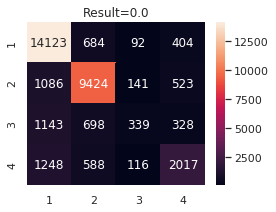

Total= 32954  Classified= 32954 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 25903 Incorrect= 7051 Correct %= 78.6035079201311 Incorrect %= 21.39649207986891


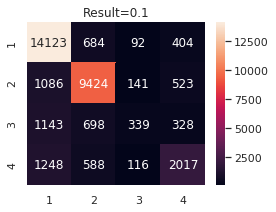

Total= 32954  Classified= 32954 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 25903 Incorrect= 7051 Correct %= 78.6035079201311 Incorrect %= 21.39649207986891


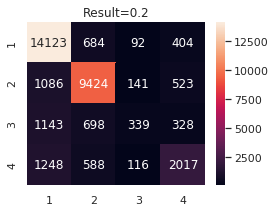

Total= 32954  Classified= 32951 Discarded= 3 recovered percent= 99.99089640104388 discarded percent= 0.009103598956120654
Correct= 25902 Incorrect= 7049 Correct %= 78.60762951048527 Incorrect %= 21.392370489514732


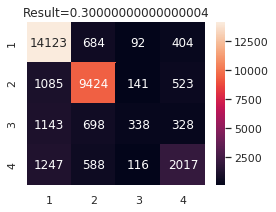

Total= 32954  Classified= 32832 Discarded= 122 recovered percent= 99.62978697578443 discarded percent= 0.3702130242155732
Correct= 25870 Incorrect= 6962 Correct %= 78.79507797270955 Incorrect %= 21.204922027290447


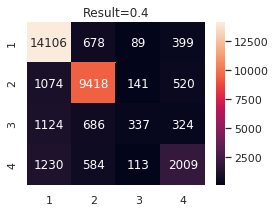

Total= 32954  Classified= 32264 Discarded= 690 recovered percent= 97.90617224009225 discarded percent= 2.09382775990775
Correct= 25667 Incorrect= 6597 Correct %= 79.55306223654847 Incorrect %= 20.446937763451526


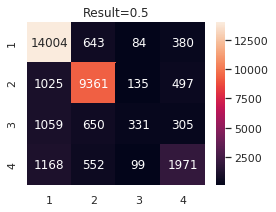

Total= 32954  Classified= 30967 Discarded= 1987 recovered percent= 93.97038295806276 discarded percent= 6.029617041937246
Correct= 25199 Incorrect= 5768 Correct %= 81.37372041205154 Incorrect %= 18.62627958794846


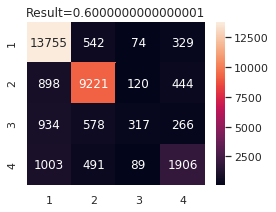

Total= 32954  Classified= 29651 Discarded= 3303 recovered percent= 89.97693754931116 discarded percent= 10.02306245068884
Correct= 24667 Incorrect= 4984 Correct %= 83.19112340224612 Incorrect %= 16.80887659775387


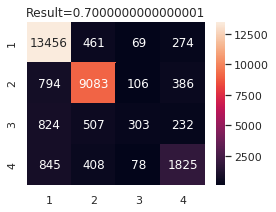

Total= 32954  Classified= 28063 Discarded= 4891 recovered percent= 85.15809916853796 discarded percent= 14.841900831462038
Correct= 23925 Incorrect= 4138 Correct %= 85.25460570858425 Incorrect %= 14.745394291415742


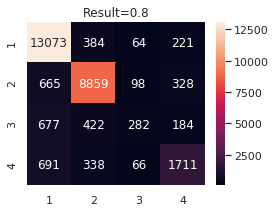

Total= 32954  Classified= 26015 Discarded= 6939 recovered percent= 78.94337561449292 discarded percent= 21.05662438550707
Correct= 22863 Incorrect= 3152 Correct %= 87.88391312704209 Incorrect %= 12.116086872957908


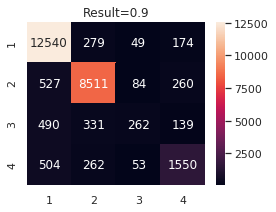

In [55]:
from pycm import *
stats={}
for threshold in np.arange(0,1,0.1):
    result=cm_for_threshold(LX_test,y_test_predicted,y_test_mod,threshold=threshold,dump_errors=True)
    print("Total=",result['total']," Classified=", result['recovered'], 
          "Discarded=",result['discarded'], "recovered percent=",result['recovered']/result['total'] *100, "discarded percent=",(result['total']-result['recovered'])/result['total']*100)
    print('Correct=',result['correct'],'Incorrect=',result['incorrect'], 
          'Correct %=',result['correct']/result['recovered'] * 100,'Incorrect %=',result['incorrect']/result['recovered'] * 100) 
    cm=result['cm']
    cm_heatmap_for(cm.table, threshold)
#    print(cm)
    stats[str(threshold)]=result

In [56]:
def export_errors(file_name,labels, predictions, actuals):
    with open(run+"/"+file_name, "w") as file:
        for index,pred in enumerate(predictions):
            if actuals[index]!=pred:
                file.write(labels[index]+','+ str(pred)+ ','+str(actuals[index])+'\n')
                
def export_matrix(file_name,labels, matrix):
    with open(run+"/"+file_name, "w") as file:
        for index,mat_row in enumerate(matrix):
            file.write(labels[index])
            for elem in mat_row:
                file.write(','+ str(elem))
            file.write('\n')
                

In [57]:
export_matrix('rep5-test_predictions.csv',LX_test, y_test_predicted)
export_matrix('rep5-test_actuals.csv',LX_test, y_test_mod)


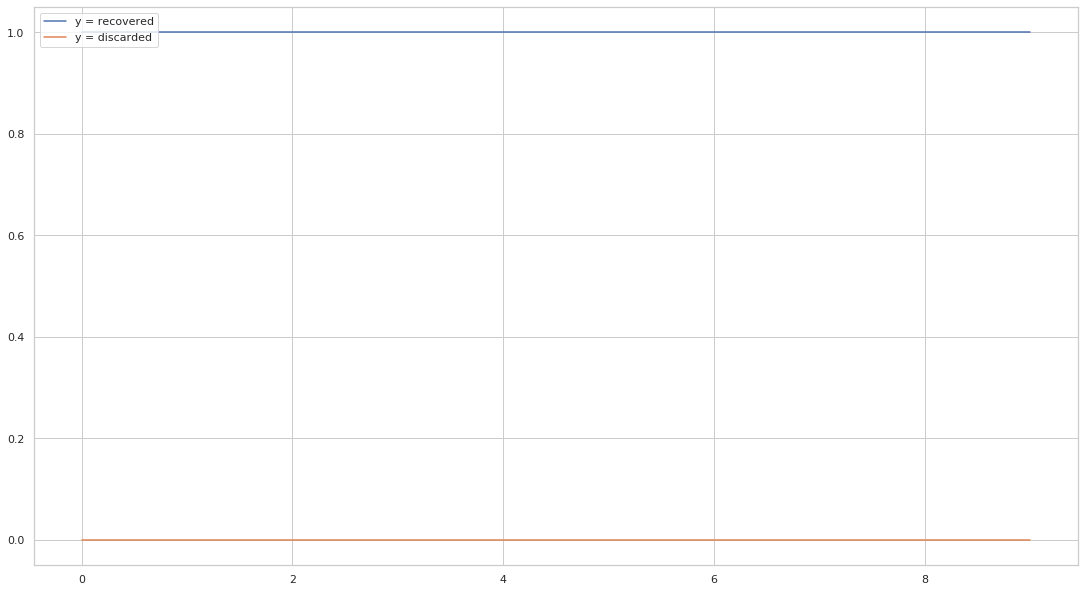

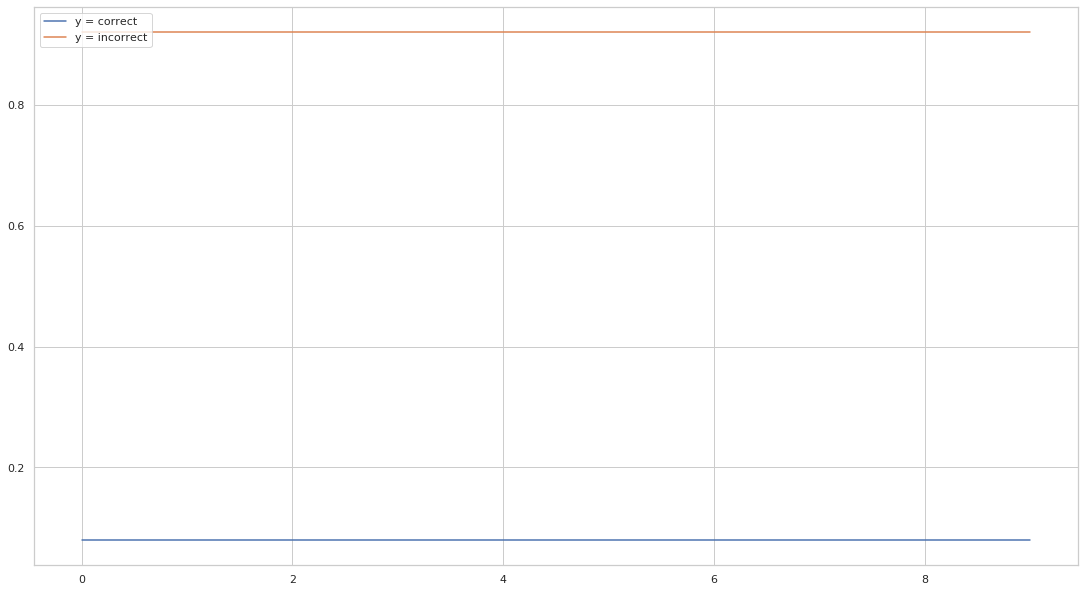

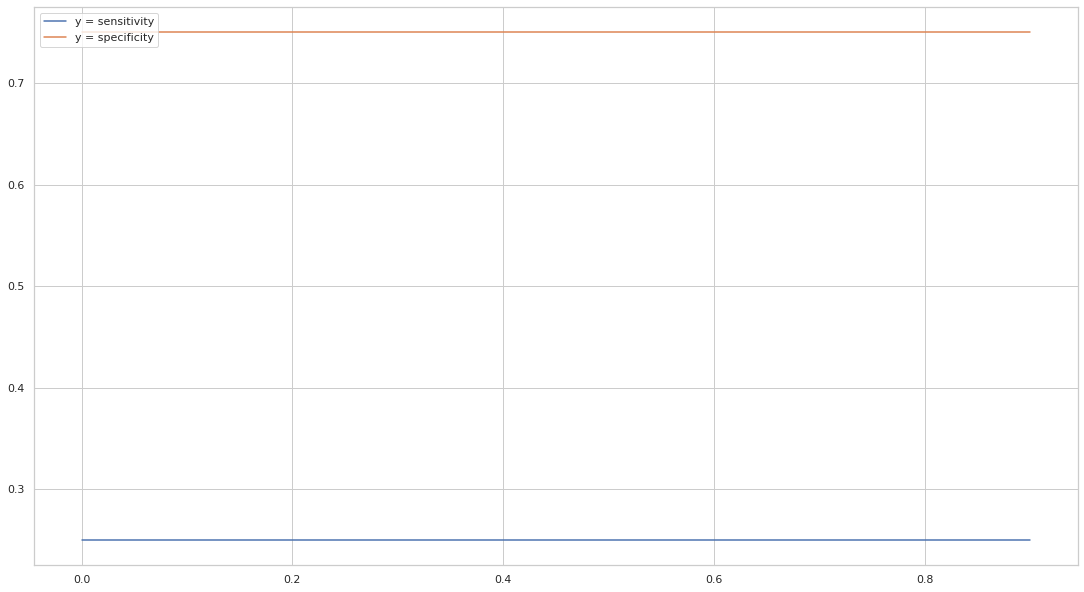

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08] [0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92] [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]
0.0 1.0 0.0 0.08 0.92
0.1 1.0 0.0 0.08 0.92
0.2 1.0 0.0 0.08 0.92
0.30000000000000004 1.0 0.0 0.08 0.92
0.4 1.0 0.0 0.08 0.92
0.5 1.0 0.0 0.08 0.92
0.6000000000000001 1.0 0.0 0.08 0.92
0.7000000000000001 1.0 0.0 0.08 0.92
0.8 1.0 0.0 0.08 0.92
0.9 1.0 0.0 0.08 0.92


In [83]:
def calc_avg(dict):
    vals=np.array(list(dict.values()))
    return(np.mean(vals))

def calculate_stats(result):
    confidence=[]
    recovered=[]
    discarded=[]
    correct=[]
    incorrect=[]
    accuracy=[]    
    sensitivity=[]
    specificity=[]
    roc=[]
    for conf,scores in result.items():
        confidence.append(float(conf))
        recovered.append(scores['recovered']/scores['total'])
        discarded.append(scores['discarded']/scores['total'])
        correct.append(scores['correct']/scores['recovered'])
        incorrect.append(scores['incorrect']/scores['recovered'])
        accuracy.append(scores['cm'].Overall_ACC)
        sensitivity.append(calc_avg(scores['cm'].TPR))
        specificity.append(calc_avg(scores['cm'].TNR))
        roc.append(calc_avg(scores['cm'].AUC))    
    return(confidence,recovered,discarded,correct,incorrect,accuracy,sensitivity,specificity,roc)
        
    plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

def graph_summary_for(result):
    confidence,recovered,discarded,correct,incorrect,accuracy,sensitivity,specificity,roc=calculate_stats(result)
    plt.plot(recovered)
    plt.plot(discarded)
    plt.legend(['y = recovered', 'y = discarded'], loc='upper left')
    plt.show()
    
    plt.plot(correct)
    plt.plot(incorrect)
    plt.legend(['y = correct', 'y = incorrect'], loc='upper left')
    plt.show()
    
    plt.plot(confidence,sensitivity)
    plt.plot(confidence,specificity)
    plt.legend(['y = sensitivity', 'y = specificity'], loc='upper left')
    plt.show()
    print(confidence,recovered,discarded,correct,incorrect,accuracy)
    for index,cf in enumerate(confidence):
        print(cf,recovered[index],discarded[index],correct[index],incorrect[index])

graph_summary_for(stats)

[2584, 2304, 280, 0.891640866873065, 0.10835913312693499]
Predict          1      2      3      4      
Actual
1                516    43     20     15     

2                121    271    12     7      

3                4      12     762    13     

4                7      11     15     755    





Overall Statistics : 

95% CI                                                           (0.87966,0.90363)
AUNP                                                             0.9288
AUNU                                                             0.91339
Bennett S                                                        0.85552
CBA                                                              0.83832
Chi-Squared                                                      5459.63637
Chi-Squared DF                                                   9
Conditional Entropy                                              0.53897
Cramer V                                                         0.83922
Cross Entro

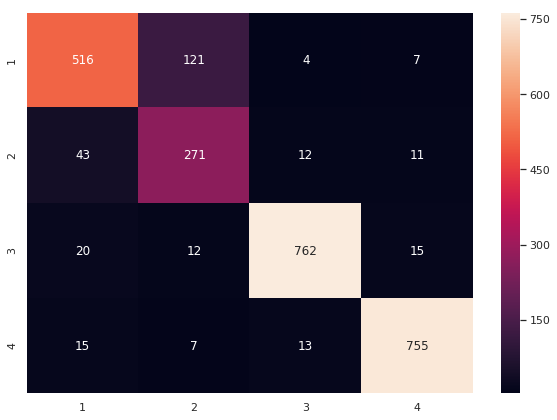

In [42]:
cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
cm_table=cm.table
print(totals_for(cm_table))
print(cm)
#cm.relabel(mapping={0:"117",1:"63",2:"81",3:"103",4:"999"})
df_cm = pd.DataFrame(cm.table, index =[1,2,3,4],
                  columns = [1,2,3,4])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g' )

In [ ]:
threshold=0.9
pv,av=vectorise_selected_with_threshold(y_test_predicted,y_test,threshold)
recognised=np.count_nonzero(pv)


In [ ]:
cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
cm_table=cm.table
print(totals_for(cm_table))
print(cm)
#cm.relabel(mapping={0:"117",1:"63",2:"81",3:"103",4:"999"})
df_cm = pd.DataFrame(cm.table, index =[1,2,3,4],
                  columns = [1,2,3,4])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g' )